# Data Science Bootcamp - Project 4
Team Members:
* Ben Calderaio
* Conrad Urffer
* Clara Bucar
* Tammy Lacher
* Jeff Pinegar

Due Date: March 22, 2023

---
# Neural Network Model
Model fitting using deep learning neural networks

### Imports

In [1]:
# imports
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
from sql_config import protocol, username, password, host, port, database_name
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import csv
import os

# Oversampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

---
# Load Clean Data from Postgres

In [2]:
# create db connection and engine
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

# Read in the postgres cleaned data in table "app_data_clean" into a dataframe
df_clean = pd.read_sql_query('select * from proj4_sch.app_data_clean', con=engine)

In [3]:
# Check the dataframe
df_clean.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,2.0,0.0,-617.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
# Check the dataframe continued
df_clean.describe(include = 'all').round(3)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DOC_COUNT
count,307505.000,307505,307505,307505,307505,307505.000,3.075050e+05,307505.000,307505.000,307505.000,...,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000,307505.000
unique,NaN,2,2,2,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Cash loans,F,N,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,278232,202447,202920,213306,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.081,NaN,NaN,NaN,NaN,0.416,1.687967e+05,599028.395,27107.580,537914.488,...,1.401,0.100,-962.859,0.006,0.006,0.030,0.231,0.230,1.643,0.930
std,0.272,NaN,NaN,NaN,NaN,0.715,2.371248e+05,402493.887,14494.547,369633.198,...,2.377,0.362,826.814,0.078,0.103,0.191,0.857,0.744,1.856,0.344
min,0.000,NaN,NaN,NaN,NaN,0.000,2.565000e+04,45000.000,0.000,0.000,...,0.000,0.000,-4292.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,NaN,NaN,NaN,NaN,0.000,1.125000e+05,270000.000,16524.000,238500.000,...,0.000,0.000,-1570.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,0.000,NaN,NaN,NaN,NaN,0.000,1.471500e+05,513531.000,24903.000,450000.000,...,0.000,0.000,-757.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000
75%,0.000,NaN,NaN,NaN,NaN,1.000,2.025000e+05,808650.000,34596.000,679500.000,...,2.000,0.000,-274.000,0.000,0.000,0.000,0.000,0.000,3.000,1.000


In [5]:
print(df_clean.dtypes)

TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
                               ...   
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
DOC_COUNT                       int64
Length: 71, dtype: object


In [6]:
# Check the dataframe continued
print (df_clean.shape)
print (df_clean.columns)

(307505, 71)
Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEA

---
# Prepare for machine learning

In [7]:
# Coppy dataframe to "X" so that most of my existing code will work.
X = df_clean

#### Encoding of Categorical variables using Pandas Dummies

In [8]:
# Convert categorical data using dummies.
# Convert categorical data to numeric with `pd.get_dummies`
#  YOUR CODE GOES HERE
X_dummies = pd.get_dummies(X)
print(X_dummies.columns)
X_dummies

Index(['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_0',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=133)


,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307500,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,-8456.0,...,0,0,0,0,0,1,0,0,1,0
307501,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,-4388.0,...,0,0,0,0,0,1,0,0,1,0
307502,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,-6737.0,...,0,0,0,0,1,0,0,0,1,0
307503,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,-2562.0,...,0,0,0,0,0,1,0,0,1,0


---
# Start Model Building

#### Seperate out the target

In [9]:
# Seperate out the dependent and independen variables
# Split our preprocessed data into our features and target arrays

# Seperate out thetarget
y = X_dummies["TARGET"].values

# Drop target (y) from the dataframe to get the independent variables
# this is the feature list
X = X_dummies.drop("TARGET", axis=1)

# Get a list of the independent variables
independent_variables = X_dummies.columns
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0,1,0,0,1,0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,1,0,0,0,0,0,0,0,1,0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0,0,0,1,0,0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,0,0,0,1,0,0
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0,0,0,1,0,0


### Split and Scale

In [10]:
# Split the preprocessed data into a training and testing dataset
# Split the data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

# Not scaling y since it is only 0 or 1
# Create a StandardScaler() model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

# Transform the training and testing data by using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---
# Start Neural Network Model

In [11]:

###############  Changable item in the model   ################################
nEpoch = 10             # Number of epoch for fitting the data
inputs = 132            # Number of indepent variable in the data frame
lay_1_n = 60            # Number of neurons in the first layer 
lay_2_n = 30            # Number of neurons in the second layer
lay_3_n = 15             # Number of neurons in the second layer
lay_4_n = 0             # Number of neurons in the second layer
lay_5_n = 0             # Number of neurons in the second layer
lay_6_n = 0             # Number of neurons in the second layer
act1 = "relu"           # Layer 1 activation fuction 
act2 = "relu"           # Layer 2 activation fuction 
act3 = "relu"           # Layer 3 activation fuction 
act4 = "relu"           # Layer 4 activation fuction 
act5 = "relu"           # Layer 5 activation fuction 
act6 = "relu"           # Layer 5 activation fuction 
actout = "sigmoid"      # Output 1 activation fuction = Sigmoid because it is good for binary classification.

################### End Chanageble items #################################

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#  YOUR CODE GOES HERE

# Create a Keras Sequential model and add more than one Dense hidden layer
nn = tf.keras.models.Sequential()

# 1st hidden layer with 6 neurons
# two inputs
nn.add(tf.keras.layers.Dense(units=lay_1_n, activation=act1, input_dim=inputs))

# 2nd hidden layer
if lay_2_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_2_n, activation=act2))

# 3rd hidden layer
if lay_3_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_3_n, activation=act3))

# 4th hidden layer
if lay_4_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_4_n, activation=act4))

# 5th hidden layer
if lay_5_n > 0:
      nn.add(tf.keras.layers.Dense(units=lay_5_n, activation=act5))

# 6th hidden layer
if lay_6_n > 0:
       nn.add(tf.keras.layers.Dense(units=lay_6_n, activation=act6))

# output layer for classification.
nn.add(tf.keras.layers.Dense(units=1, activation=actout))

# Check the structure of the Sequential model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                7980      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 16        
Total params: 10,291
Trainable params: 10,291
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Compile the model
X_for_train = X_train_scaled
y_for_train = y_train
X_for_test = X_test_scaled
y_for_test = y_test

#  YOUR CODE GOES HERE
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_model = nn.fit(X_for_train, y_for_train, epochs=nEpoch)

# Calculate TEST data Loss and Accuracy
model_loss, model_accuracy = nn.evaluate(X_for_test,y_for_test,verbose=2)
data = [model_accuracy,model_loss,nEpoch,inputs,lay_1_n,lay_2_n,lay_3_n,lay_4_n,lay_5_n,lay_6_n,act1,act2,act3,act4,act5,act6,actout] #the data

# write the model and results to a file.
with open ('Run_results.csv', 'a', encoding='utf-8', newline='') as f:
    writer = csv.writer(f) #this is the writer object
    # writer.writerow(column_name) # this will list out the names of the columns which are always the first entrries
    writer.writerow(data) #this is the data
f.close()

Epoch 1/10
2883/2883 [==============================] - 3s 784us/step - loss: 0.2655 - accuracy: 0.9192
Epoch 2/10
2883/2883 [==============================] - 2s 812us/step - loss: 0.2568 - accuracy: 0.9193
Epoch 3/10
2883/2883 [==============================] - 2s 843us/step - loss: 0.2542 - accuracy: 0.9193
Epoch 4/10
2883/2883 [==============================] - 2s 846us/step - loss: 0.2516 - accuracy: 0.9193
Epoch 5/10
2883/2883 [==============================] - 2s 850us/step - loss: 0.2493 - accuracy: 0.9193
Epoch 6/10
2883/2883 [==============================] - 2s 841us/step - loss: 0.2463 - accuracy: 0.9193
Epoch 7/10
2883/2883 [==============================] - 3s 868us/step - loss: 0.2434 - accuracy: 0.9192
Epoch 8/10
2883/2883 [==============================] - 3s 881us/step - loss: 0.2400 - accuracy: 0.9198
Epoch 9/10
2883/2883 [==============================] - 2s 852us/step - loss: 0.2370 - accuracy: 0.9200
Epoch 10/10
2883/2883 [==============================] - 2s 842u

#### Plot Loss and Accuracy

6727/6727 - 4s - loss: 0.2687 - accuracy: 0.9179
Loss: 0.2686787545681, Accuracy: 0.9179295301437378


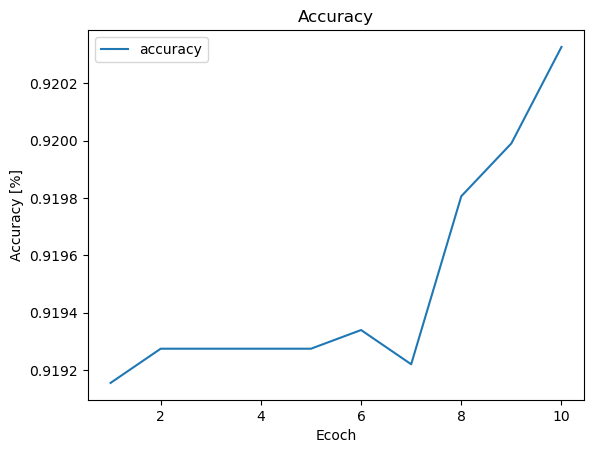

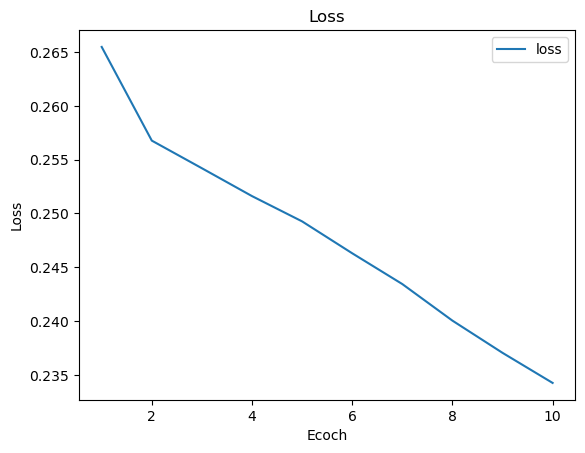

In [13]:
# Evaluate the model using the test data

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the accuracy and loss
history_df.plot(y="accuracy", xlabel='Ecoch', ylabel='Accuracy [%]', title='Accuracy')
history_df.plot(y="loss", xlabel='Ecoch', ylabel='Loss', title='Loss')

# Calculate TEST data Loss and Accuracy
model_loss, model_accuracy = nn.evaluate(X_for_test,y_for_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [14]:
# Export our model to HDF5 file

now = datetime.now()
acc = str(int(model_accuracy*10000))
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-weights.hdf5"
nn.save_weights(filename)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-model.h5"
nn.save(filename)

#### Build a dataframe of predicted value based on the model

In [15]:
# Set the threshold for what is classified as a 0 or 1
Threshold = 0.5
y_pred = nn.predict(X_for_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred_df.loc[y_pred_df['y_pred']>=Threshold ]= int(1)
y_pred_df.loc[y_pred_df['y_pred']<Threshold ]= int(0)
#y_pred['y_pred'].value_counts()

In [16]:
display(y_pred_df.dtypes)
y_pred = y_pred_df.astype({"y_pred":'int'})
display(y_pred_df.dtypes)

y_pred    float32
dtype: object

y_pred    float32
dtype: object

In [17]:
# Check the number of occurrences per target value in the testing data
unique_elements_test, counts_elements_test = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the `y_test` array:")
print(np.asarray((unique_elements_test, counts_elements_test)))

Frequency of unique values of the `y_test` array:
[[     0      1]
 [214502    752]]


In [18]:
# continue the evaluation of the model
y_true = y_test

# Predict  - using the model calculate results for the text data
# y_pred = nn.predict(X_test_scaled)
y_pred = y_pred_df

# create and evaluate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"True positives (TP): {tp}")
print(f"True negatives (TN): {tn}")
print(f"False positives (FP): {fp}")
print(f"False negatives (FN): {fn}")
precision = tp / (tp + fp)
print(f'precision =  {precision}')
accuracy = (tp + tn)/(tp+tn+fp+fn)
print(f'accuracy =  {accuracy}')
sensitivity = tp / (tp + fn)
print(f'sensitivity =  {sensitivity}')
F1_j = 2*tp/(2*tp+fn+fp)
print(f'F1 = {F1_j}')
print(classification_report(y_true, y_pred))

True positives (TP): 232
True negatives (TN): 197356
False positives (FP): 520
False negatives (FN): 17146
precision =  0.30851063829787234
accuracy =  0.9179295158278127
sensitivity =  0.013350212912878351
F1 = 0.025592939878654165
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    197876
           1       0.31      0.01      0.03     17378

    accuracy                           0.92    215254
   macro avg       0.61      0.51      0.49    215254
weighted avg       0.87      0.92      0.88    215254



---
# Random Oversample

#### Split, Scale and Oversample

In [20]:
# Split the preprocessed data into a training and testing dataset
# Split the data into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

# Not scaling y since it is only 0 or 1
# Create a StandardScaler() model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

# Transform the training and testing data by using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train_scaled, y_train)

In [21]:
# Compile the model
nEpoch = 50
X_for_train = X_train_ros
y_for_train = y_train_ros
X_for_test = X_test_scaled
y_for_test = y_test

#  YOUR CODE GOES HERE
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
fit_model = nn.fit(X_for_train, y_for_train, epochs=nEpoch)

# Calculate TEST data Loss and Accuracy
model_loss, model_accuracy = nn.evaluate(X_for_test,y_for_test,verbose=2)
data = [model_accuracy,model_loss,nEpoch,inputs,lay_1_n,lay_2_n,lay_3_n,lay_4_n,lay_5_n,lay_6_n,act1,act2,act3,act4,act5,act6,actout] #the data

# write the model and results to a file.
with open ('Run_results.csv', 'a', encoding='utf-8', newline='') as f:
    writer = csv.writer(f) #this is the writer object
    # writer.writerow(column_name) # this will list out the names of the columns which are always the first entrries
    writer.writerow(data) #this is the data
f.close()

Epoch 1/50
5301/5301 [==============================] - 5s 800us/step - loss: 0.5036 - accuracy: 0.7504
Epoch 2/50
5301/5301 [==============================] - 5s 936us/step - loss: 0.4457 - accuracy: 0.7903
Epoch 3/50
5301/5301 [==============================] - 5s 913us/step - loss: 0.4139 - accuracy: 0.8104
Epoch 4/50
5301/5301 [==============================] - 5s 917us/step - loss: 0.3916 - accuracy: 0.8241
Epoch 5/50
5301/5301 [==============================] - 5s 952us/step - loss: 0.3747 - accuracy: 0.8335
Epoch 6/50
5301/5301 [==============================] - 5s 904us/step - loss: 0.3614 - accuracy: 0.8413
Epoch 7/50
5301/5301 [==============================] - 5s 896us/step - loss: 0.3513 - accuracy: 0.8476
Epoch 8/50
5301/5301 [==============================] - 5s 970us/step - loss: 0.3433 - accuracy: 0.8524
Epoch 9/50
5301/5301 [==============================] - 5s 951us/step - loss: 0.3352 - accuracy: 0.8564
Epoch 10/50
5301/5301 [==============================] - 5s 955u

6727/6727 - 4s - loss: 1.0688 - accuracy: 0.7769
Loss: 1.0688445568084717, Accuracy: 0.7768682837486267
Frequency of unique values of the `y_test` array:
[[     0      1]
 [160648  54606]]
True positives (TP): 7294
True negatives (TN): 150564
False positives (FP): 47312
False negatives (FN): 10084
precision =  0.13357506501117095
accuracy =  0.7333568714170237
sensitivity =  0.4197260904592013
F1 = 0.20265614581018004
              precision    recall  f1-score   support

           0       0.94      0.76      0.84    197876
           1       0.13      0.42      0.20     17378

    accuracy                           0.73    215254
   macro avg       0.54      0.59      0.52    215254
weighted avg       0.87      0.73      0.79    215254



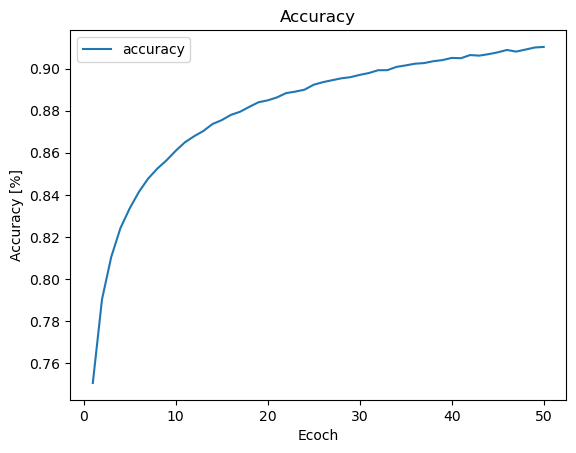

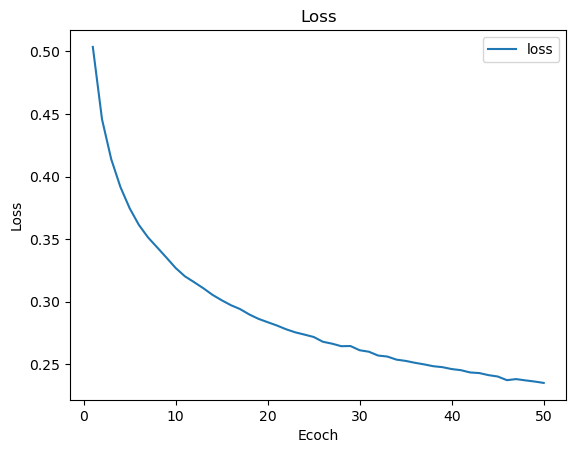

In [22]:
# --------------------------------
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the accuracy and loss
history_df.plot(y="accuracy", xlabel='Ecoch', ylabel='Accuracy [%]', title='Accuracy')
history_df.plot(y="loss", xlabel='Ecoch', ylabel='Loss', title='Loss')

# Calculate TEST data Loss and Accuracy
model_loss, model_accuracy = nn.evaluate(X_for_test,y_for_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# ------------------------------------
# Export our model to HDF5 file

now = datetime.now()
acc = str(int(model_accuracy*10000))
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-weights.hdf5"
nn.save_weights(filename)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filename = now.strftime("%Y-%m-%d-%H%M%S-")+acc+"-model.h5"
nn.save(filename)

# -----------------------------------
# Set the threshold for what is classified as a 0 or 1
Threshold = 0.25
y_pred = nn.predict(X_for_test)
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred_df.loc[y_pred_df['y_pred']>=Threshold ]= int(1)
y_pred_df.loc[y_pred_df['y_pred']<Threshold ]= int(0)
#y_pred['y_pred'].value_counts()

# ------------------------------------
y_pred = y_pred_df.astype({"y_pred":'int'})

# ------------------------------------
# Check the number of occurrences per target value in the testing data
unique_elements_test, counts_elements_test = np.unique(y_pred, return_counts=True)
print("Frequency of unique values of the `y_test` array:")
print(np.asarray((unique_elements_test, counts_elements_test)))

# -------------------------------------
# continue the evaluation of the model
y_true = y_test

# Predict  - using the model calculate results for the text data
# y_pred = nn.predict(X_test_scaled)
y_pred = y_pred_df

# create and evaluate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"True positives (TP): {tp}")
print(f"True negatives (TN): {tn}")
print(f"False positives (FP): {fp}")
print(f"False negatives (FN): {fn}")
precision = tp / (tp + fp)
print(f'precision =  {precision}')
accuracy = (tp + tn)/(tp+tn+fp+fn)
print(f'accuracy =  {accuracy}')
sensitivity = tp / (tp + fn)
print(f'sensitivity =  {sensitivity}')
F1_j = 2*tp/(2*tp+fn+fp)
print(f'F1 = {F1_j}')
print(classification_report(y_true, y_pred))